In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from joblib import Parallel, delayed

np.set_printoptions(suppress=True, precision=6)
pd.set_option('display.float_format', '{:.6f}'.format)

2023-09-27 12:00:40.011748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 12:00:40.727559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("data/otu_table_example.csv", index_col="Unnamed: 0").T

In [3]:
print(df.head())

             1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8        0        0        0        0        0        0        0   
E000823.2.6        0        0        0        0        0        0        0   
E000823.4.0        0        0        0        0        0        0        0   
E000823.5.0        0        0        0        0        0        0        0   
E000823.5.7        0        0        0        0        0        0        0   

             4327628  326749   183857   ...  317924   4294457  2655741  \
E000823.1.8        0        0        0  ...        0        0        0   
E000823.2.6        0        0        0  ...        0        0        0   
E000823.4.0        0        0        0  ...        0        0        0   
E000823.5.0        0        0        0  ...        0        0        0   
E000823.5.7        0        0        0  ...        0        0        0   

             858535   186092   299820   225846   4306049  366846   1124370  
E000823.1

In [4]:
# get rid of features that are way too sparse
zero_values_percentage_cutoff = .5

zero_counts = pd.Series([sum(df[col] == 0) for col in df.columns], index=df.columns)
zero_pcts = zero_counts / len(df)
populated_feats = zero_pcts[zero_pcts < zero_values_percentage_cutoff].index
df = df[populated_feats]

In [5]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0,0,5,0,0,15,1,3,0,1,...,0,12,2,0,0,52,22,78,65,7
E000823.2.6,0,4,3,0,0,12,1,4,0,10,...,0,4,2,1,0,60,25,97,90,2
E000823.4.0,0,4,5,0,0,23,2,1,0,4,...,0,7,3,0,0,80,25,170,170,4
E000823.5.0,0,0,1,0,0,6,0,0,0,4,...,0,4,0,3,0,31,13,46,85,0
E000823.5.7,0,5,3,6,0,18,1,0,0,0,...,0,10,11,1,0,53,44,131,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,101,2117,6,11,17,15,3,7,498,31,...,116,2,30,5,758,177,14,389,5003,7
E014086.32.4,33,2520,19,5,63,19,20,6,1542,66,...,271,16,0,2,1067,291,23,1396,10760,50
E014086.33.5,3,2447,20,2,138,56,6,13,449,38,...,134,6,0,2,183,551,22,1323,8449,46
E014086.34.4,20,1402,5,0,16,43,2,5,240,30,...,103,1,0,6,72,312,5,931,4769,28


In [200]:
def forward_rolling_average(series, window_size):
    
    original_idxs = series.index
    
    series = series.reset_index(drop=True)
    
    for idx in range(len(series) - window_size):
       
        next_vals = series[idx:idx+window_size]
        
        #print(idx, next_vals.tolist())
        #print(next_vals.mean())
        
        series[idx] = next_vals.mean()
    
    series.index = original_idxs
    
    series = series.iloc[:-window_size]
            
    return series
    

In [201]:
#window_size = 3
#sequence = pd.Series([0,1,2,3,4,5,6,7,8,9,10])

#forward_rolling_average(sequence, window_size).tolist()
# out [1, 2, 3, 4, 5, 6, 7, 8]

In [202]:
#def smooth_it_out(df, rolling_window=5):
#    # Define the window size for the rolling average
#    window_size = 5
#    
#    # Apply rolling mean to numeric columns
#    df = df.shift(-window_size + 1).rolling(window=window_size).mean()
#    
#    return df

In [203]:
def smooth_it_out(df, window_size=5, n_jobs=32):
    
    smooth_cols = Parallel(n_jobs=n_jobs)(delayed(forward_rolling_average)(df[col], window_size) for col in df.columns)
    
    for idx, col in enumerate(df.columns):
        df[col] = smooth_cols[idx]
        
    df = df.iloc[:-window_size]
    
    return df

In [204]:
def feature_wise_scaling(df):
    for col in df.columns:
        _min_ = df[col].min()
        _max_ = df[col].max()
        
        df[col] = (df[col] - _min_) / (_max_ - _min_)
        
    return df      

In [240]:
def cut_to_sequences(feats_df, seq_length):
    num_features = len(feats_df.columns)
    
    X_sequences = []
    y_targets = []
    
    for i in range(len(feats_df) - seq_length):
        X_sequences.append(feats_df.iloc[i:i+seq_length])
        y_targets.append(feats_df.iloc[i+seq_length])
    
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    X_sequences = X_sequences.reshape(-1, seq_length, num_features)
    
    return X_sequences, y_targets

In [241]:
list(range(10,20))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [251]:
example_df = pd.DataFrame()
example_df["one"] = range(1,10)
example_df["two"] = range(11,20)
example_df["three"] = range(21,30)
print(example_df)

   one  two  three
0    1   11     21
1    2   12     22
2    3   13     23
3    4   14     24
4    5   15     25
5    6   16     26
6    7   17     27
7    8   18     28
8    9   19     29


In [ ]:
X_sequences, y_targets = cut_to_sequences(feats_df=example_df, seq_length=3)

In [252]:
print(X_sequences[0])

[[ 1 11 21]
 [ 2 12 22]
 [ 3 13 23]]


In [253]:
print(y_targets[0])

[ 4 14 24]


In [206]:
def mae_ignore_zeros(y_true, y_pred, false_positives_penalty_factor=0.1):
    
    # Find indices where y_true is not zero
    non_zero_indices = tf.where(tf.not_equal(y_true, 0))
    
    # Gather the non-zero elements from y_true and y_pred using the indices
    y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
    y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)
    
    y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
    y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)
    
    # Calculate MAE on the non-zero elements
    mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))
    
    # Find indices where y_true is zero 
    zero_indices = tf.where(tf.equal(y_true, 0))
    
    # Gather the corresponding y_pred values
    y_pred_zero = tf.gather_nd(y_pred, zero_indices)
    
    y_pred_zero = tf.cast(y_pred_zero, tf.float64)
    
    # Calculate the average of false positives
    false_positives_avg = tf.reduce_mean(y_pred_zero)
    
    # Combine the MAE on non-zero elements with the average of false positives
    mae_ignore_zeros = mae_non_zero + (false_positives_avg * false_positives_penalty_factor)
    
    return mae_ignore_zeros

In [207]:
y_true = [0,0,10]
y_pred = [0,0,0]

keras.losses.mae(y_true, y_pred)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [208]:
mae_ignore_zeros(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=10.0>

In [209]:
df = smooth_it_out(df=df, window_size=5)
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,2.600000,3.400000,1.200000,0.000000,14.800000,1.000000,1.600000,0.000000,3.800000,...,0.000000,7.400000,3.600000,1.000000,0.000000,55.200000,25.800000,104.400000,93.000000,2.600000
E000823.2.6,34.800000,3.200000,2.400000,5.200000,0.000000,12.000000,0.800000,1.200000,0.000000,5.200000,...,0.000000,5.400000,7.800000,1.600000,0.600000,48.600000,22.200000,94.000000,91.000000,1.200000
E000823.4.0,34.800000,3.000000,2.800000,5.600000,0.000000,26.000000,2.000000,0.800000,0.000000,3.200000,...,0.000000,5.600000,8.200000,1.800000,0.600000,70.200000,19.800000,114.400000,290.000000,0.800000
E000823.5.0,34.800000,2.400000,1.800000,22.400000,0.000000,22.000000,2.000000,0.600000,0.000000,2.800000,...,0.000000,5.200000,32.400000,1.800000,0.800000,62.600000,17.200000,87.000000,270.600000,0.000000
E000823.5.7,34.800000,2.400000,3.400000,22.400000,13.400000,22.400000,2.200000,0.600000,82.000000,3.400000,...,0.000000,4.600000,672.000000,1.200000,474.800000,58.400000,14.600000,91.000000,735.800000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,35.600000,1354.200000,3.000000,0.600000,16.600000,2.600000,3.400000,4.600000,263.400000,17.400000,...,83.200000,3.600000,0.200000,4.200000,404.800000,110.800000,9.000000,217.400000,2899.000000,17.400000
E014086.23.4,55.800000,1703.800000,3.200000,2.800000,17.800000,5.200000,3.600000,6.000000,336.400000,23.000000,...,105.000000,3.600000,6.200000,4.800000,550.600000,144.200000,10.800000,289.000000,3600.600000,12.600000
E014086.24.5,62.400000,1898.000000,6.600000,3.800000,30.000000,8.400000,6.800000,6.200000,636.200000,34.600000,...,158.000000,6.400000,6.200000,4.800000,754.000000,174.200000,14.400000,492.600000,5270.800000,19.600000
E014086.26.4,39.200000,1801.600000,10.400000,3.800000,52.200000,19.600000,7.200000,7.800000,679.000000,35.800000,...,174.600000,7.600000,6.200000,4.000000,639.400000,255.600000,17.000000,691.200000,6550.400000,22.000000


In [210]:
df = feature_wise_scaling(df)
df

/tmp/ipykernel_2479683/2433063030.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - _min_) / (_max_ - _min_)


,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


In [211]:
df.describe()

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,0.089052,0.031702,0.154616,0.046426,0.070852,0.143953,0.111693,0.281748,0.117081,0.265594,...,0.262012,0.109024,0.067214,0.252333,0.040178,0.150114,0.126984,0.129099,0.153713,0.234110
std,0.132399,0.119853,0.142942,0.100719,0.115851,0.155670,0.169502,0.220396,0.164555,0.210534,...,0.224676,0.146003,0.157864,0.201492,0.114693,0.182763,0.151668,0.139726,0.186696,0.214674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001520,0.000102,0.045977,0.004306,0.007714,0.043515,0.007921,0.090909,0.000275,0.106481,...,0.069331,0.025641,0.000409,0.102041,0.000089,0.020878,0.034449,0.032106,0.007628,0.053156
50%,0.032219,0.000307,0.126437,0.018182,0.035063,0.102389,0.047525,0.254545,0.049876,0.212963,...,0.229608,0.064103,0.003781,0.224490,0.002792,0.084820,0.078740,0.095293,0.092798,0.169435
75%,0.139894,0.004088,0.218391,0.048445,0.094670,0.188567,0.133663,0.418182,0.170857,0.376157,...,0.388662,0.142628,0.043183,0.346939,0.034347,0.214280,0.162402,0.172631,0.215682,0.372924
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


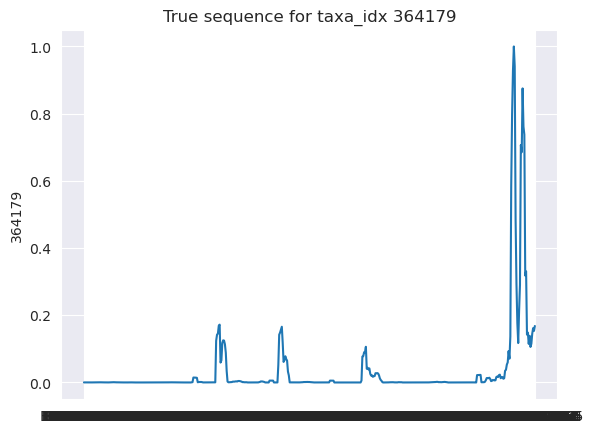

In [212]:
target_taxa = 364179

sns.lineplot(df[target_taxa])
plt.title(f"True sequence for taxa_idx {target_taxa}")
plt.show()

In [213]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

In [215]:
n_feats = len(df.columns)

In [216]:
reg = 1e-12
loss=mae_ignore_zeros

model = Sequential()
model.add(keras.Input(shape=(seq_length,n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1024)              5025792   
                                                                 
 dense_10 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_11 (Dense)            (None, 202)               413898    
                                                                 
Total params: 7538890 (28.76 MB)
Trainable params: 7538890 (28.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [217]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.05, epochs=10)

Epoch 1/10
13/13 [==============================] - 2s 65ms/step - loss: 12.1782 - mae: 0.1108 - mape: 3802325.2500 - val_loss: 6.6731 - val_mae: 0.0897 - val_mape: 674949.5000
Epoch 2/10
13/13 [==============================] - 1s 54ms/step - loss: 4.2839 - mae: 0.0985 - mape: 3674350.0000 - val_loss: 2.0223 - val_mae: 0.0928 - val_mape: 1501272.6250
Epoch 3/10
13/13 [==============================] - 1s 55ms/step - loss: 1.2151 - mae: 0.0975 - mape: 3306551.7500 - val_loss: 0.5195 - val_mae: 0.0921 - val_mape: 1066808.2500
Epoch 4/10
13/13 [==============================] - 1s 53ms/step - loss: 0.3336 - mae: 0.1029 - mape: 3563283.0000 - val_loss: 0.1763 - val_mae: 0.0941 - val_mape: 1001366.5000
Epoch 5/10
13/13 [==============================] - 1s 50ms/step - loss: 0.1513 - mae: 0.0987 - mape: 4247918.5000 - val_loss: 0.1191 - val_mae: 0.0903 - val_mape: 1573246.2500
Epoch 6/10
13/13 [==============================] - 1s 53ms/step - loss: 0.1187 - mae: 0.0983 - mape: 4477414.5000 

In [218]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 8ms/step


In [219]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [220]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
1,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
2,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
3,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
4,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
5,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
6,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
7,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
8,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
9,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [221]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.054825,0.000000,0.000000,0.000000,0.000000,0.132588,0.109611,0.221437,0.038078,0.250761,...,0.276370,0.073807,0.000000,0.189972,0.000000,0.152257,0.077038,0.199628,0.135737,0.155580
1,0.057553,0.000000,0.000000,0.000000,0.000000,0.138926,0.118121,0.233984,0.042333,0.265995,...,0.295387,0.078017,0.000000,0.200095,0.000000,0.163876,0.080993,0.212813,0.146446,0.164053
2,0.053266,0.000000,0.000000,0.000000,0.000000,0.132800,0.114946,0.212959,0.041223,0.243591,...,0.276755,0.072807,0.000000,0.181667,0.000000,0.157899,0.076066,0.203878,0.142970,0.150465
3,0.053284,0.000000,0.000000,0.000000,0.000000,0.134845,0.120498,0.211384,0.044128,0.243529,...,0.281975,0.073458,0.000000,0.179991,0.000000,0.164486,0.076781,0.209980,0.150146,0.149776
4,0.042777,0.000000,0.000000,0.000000,0.000000,0.116899,0.105003,0.160419,0.037074,0.187024,...,0.227309,0.059597,0.000000,0.136529,0.000000,0.140490,0.063756,0.179049,0.131454,0.116451
5,0.039156,0.000000,0.000000,0.002749,0.000000,0.107233,0.090394,0.145311,0.029758,0.167499,...,0.199599,0.053695,0.000000,0.124341,0.000000,0.121173,0.058044,0.158090,0.112965,0.105990
6,0.034863,0.000000,0.000000,0.006264,0.000000,0.097756,0.078316,0.125760,0.023796,0.144122,...,0.171500,0.047312,0.000000,0.108218,0.000000,0.104506,0.051983,0.139001,0.097837,0.092865
7,0.034014,0.000000,0.000000,0.007814,0.000000,0.094337,0.071781,0.122800,0.020406,0.139273,...,0.161780,0.045522,0.000000,0.106210,0.000000,0.096258,0.050247,0.130560,0.089449,0.090608
8,0.029649,0.000000,0.000000,0.012229,0.000000,0.083168,0.055310,0.104542,0.012203,0.116008,...,0.129713,0.038599,0.000000,0.091281,0.000000,0.074377,0.043539,0.106678,0.068673,0.078049
9,0.027305,0.000000,0.000000,0.014897,0.000000,0.076630,0.045050,0.095013,0.007050,0.103409,...,0.111068,0.034687,0.000000,0.083662,0.000000,0.060932,0.039737,0.092240,0.055671,0.071388


In [222]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 37, 18.316831683168317% of all taxa


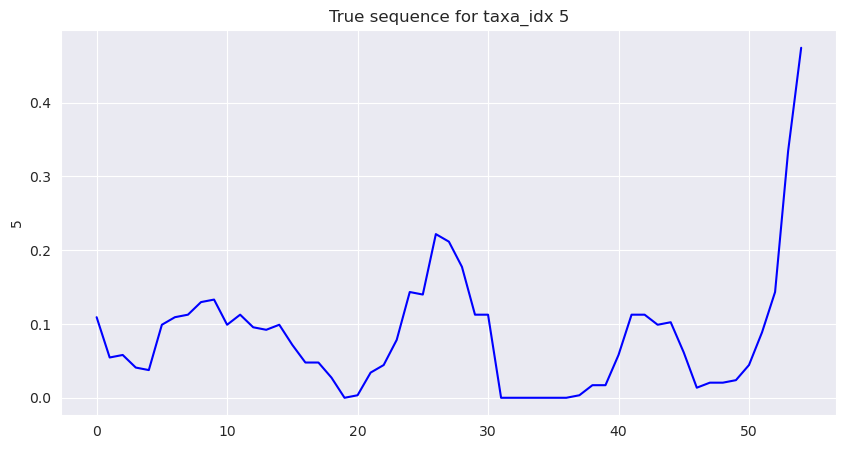

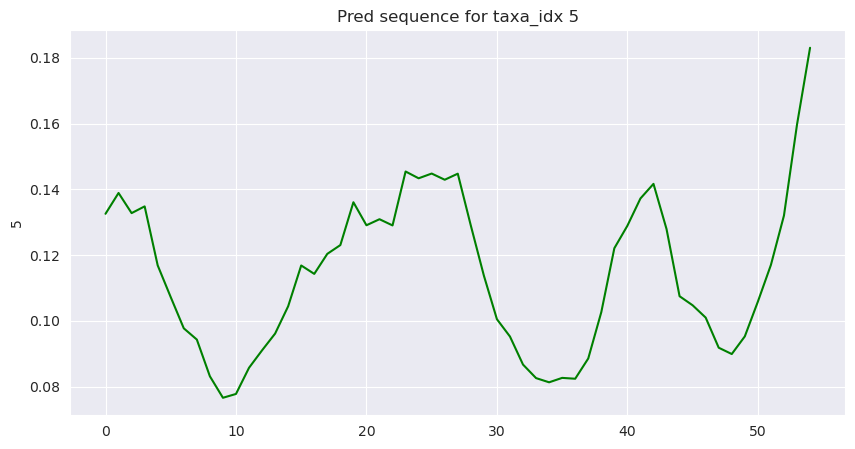

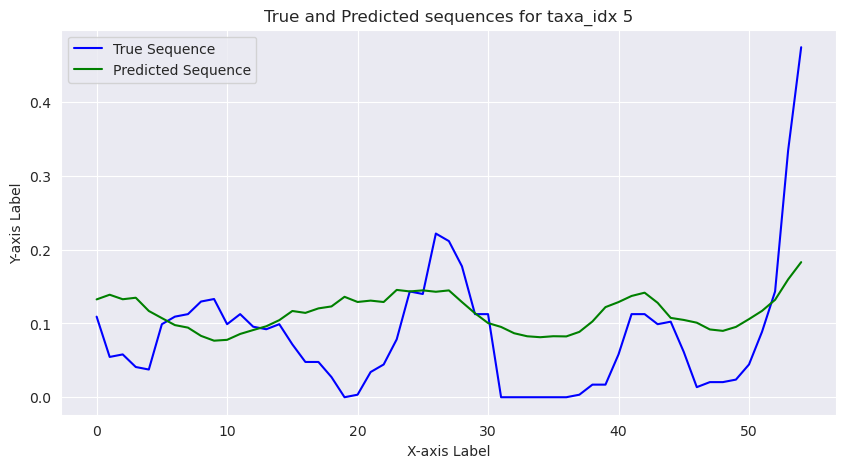

In [223]:
target_taxa = 5

figsize = (10,5)
true_colour = "blue"
pred_colour = "green"

plt.figure(figsize=figsize)
sns.lineplot(y_test_df[target_taxa], color=true_colour)
plt.title(f"True sequence for taxa_idx {target_taxa}")
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(y_pred_df[target_taxa], color=pred_colour)
plt.title(f"Pred sequence for taxa_idx {target_taxa}")
plt.show()

plt.figure(figsize=figsize) 

sns.lineplot(data=y_test_df[target_taxa], label='True Sequence', color=true_colour)
sns.lineplot(data=y_pred_df[target_taxa], label='Predicted Sequence', color=pred_colour)

plt.title(f"True and Predicted sequences for taxa_idx {target_taxa}")
plt.xlabel('X-axis Label')  # Add your x-axis label here
plt.ylabel('Y-axis Label')  # Add your y-axis label here

# Add a legend to differentiate between true and predicted sequences
plt.legend()

plt.show()


In [254]:
def calculate_percentage_errors(y_pred_df, y_test_df):
    # Description: calculate percentage errors on y_


    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_pred_df[col] - y_test_df[col]) / (y_pred_df[col] + 1e-10))
        errors_df.append(errors)

    errors_df = pd.concat(errors_df, axis=1)

    return errors_df

In [255]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.777852,2249847427.535937,1596656196.028226,55589386.665509,704449818.466574,0.543704,1.396380,0.701161,57908037.564464,0.534080,...,0.715673,0.843654,275645414.306284,0.621983,517579351.481066,1.166291,0.919146,0.541675,1.454234,1.475265
std,0.305927,2965623042.675204,1361038444.567249,94114608.361246,536075165.702982,0.369391,1.687204,0.629815,350979159.313852,0.339753,...,0.549071,0.798205,439008988.533403,0.552152,424151646.516404,1.239906,0.925548,0.422673,1.547351,1.595545
min,0.056575,40543762.873899,0.000000,0.004949,63113603.645422,0.000310,0.005326,0.019428,0.560033,0.026706,...,0.002847,0.002263,240807.182471,0.005592,223358.867715,0.018333,0.000916,0.005107,0.029632,0.024695
25%,0.548360,160386356.074687,747126426.806401,0.418737,217391301.445341,0.199514,0.216069,0.172398,2.772406,0.289271,...,0.363893,0.326845,16134081.225577,0.163704,141497842.697699,0.184713,0.306493,0.198516,0.435237,0.548619
50%,0.973198,1148512812.167328,1264367799.210834,1.105359,624123413.826946,0.563100,0.454637,0.683584,12.534539,0.491874,...,0.554143,0.669020,41418835.385064,0.532215,452078348.255947,0.850577,0.582901,0.405388,0.998286,0.875168
75%,0.993467,2916510471.775547,2068965489.617728,90909089.695324,1118513309.049416,0.805975,2.830054,1.000000,47.243030,0.757793,...,0.953836,1.000000,402750012.683250,0.964568,784771381.718019,1.819165,1.000000,0.924241,1.782562,1.976625
max,1.236888,9999999866.485682,6091953941.652198,368421047.712630,1830294505.717225,1.591119,6.338812,2.520536,2533663060.428634,1.561457,...,2.633205,3.816089,1731403641.968648,2.442286,1445355232.986282,5.253125,4.052864,1.992314,6.015821,6.871448


In [256]:
def percentile_graph(errors_df, label, y_top_lim=3, step=0.1, x_percentile=None):
    
    # hardcoded stuff
    percentile_range = np.arange(0, 101)
    x_ticks_range = range(0, 110, 10)
    
    median_errors = errors_df.median()
    median_error_percentiles = np.percentile(median_errors, percentile_range)

    plt.figure(figsize=(8,6))
    sns.lineplot(median_error_percentiles)
    plt.title(f"Percentiles of median errors {label}")
    plt.xticks(x_ticks_range)
    plt.yticks(np.arange(0, float(y_top_lim + step), step))
    plt.ylim(0, y_top_lim)
    
    if x_percentile is not None:
        sns.lineplot([x_percentile for _ in range(len(percentile_range))], color="red") # the x percentile line
    
    plt.show()

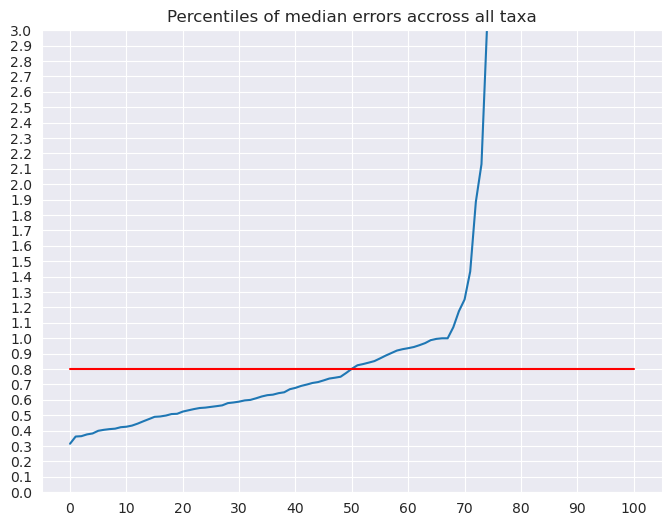

In [257]:
percentile_graph(errors_df, "accross all taxa", x_percentile=0.8)

In [258]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

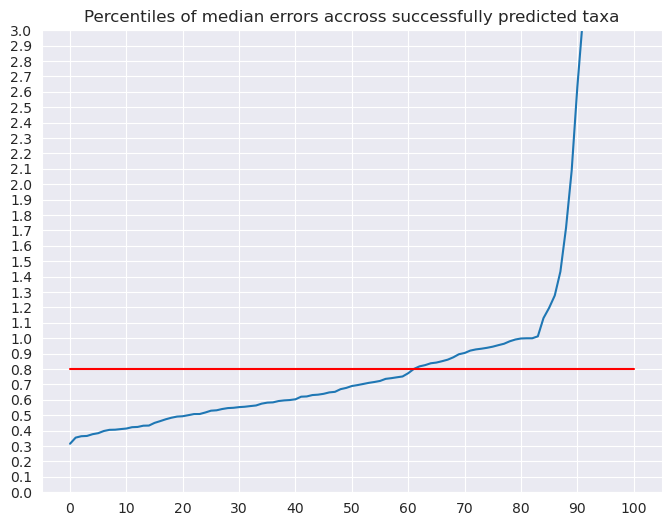

In [260]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", x_percentile=0.8)